In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [33]:
# Load TSV file
df = pd.read_csv("../data/runups-2025-05-02_14-21-01_-0600.tsv", sep="\t")

df.columns = df.columns.str.strip()

# Filter for Alaska, Hawaii, Chile, and Japan
df_ak = df[(df['Country'] == 'USA') & (df['Area'] == 'AK')].copy()
df_hi = df[(df['Country'] == 'USA') & (df['Area'] == 'HI')].copy()
df_cl = df[df['Country'] == 'CHILE'].copy()
df_jp = df[df['Country'] == 'JAPAN'].copy()

# Add region labels
df_ak['Region'] = 'Alaska'
df_hi['Region'] = 'Hawaii'
df_cl['Region'] = 'Chile'
df_jp['Region'] = 'Japan'

# Combine into one DataFrame
df_regions = pd.concat([df_ak, df_hi, df_cl, df_jp], ignore_index=True)
df_regions = df_regions[~df_regions['Location Name'].str.upper().str.contains("ALL OF")]

# Select key columns
cols = [
    'Region', 'Location Name', 'Latitude', 'Longitude',
    'Distance From Source (km)', 'Travel Hours', 'Travel Minutes',
    'Max Water Height (m)', 'Max Inundation Distance (m)',
    'Deaths', 'Injuries', 'Damage $Mil'
]

df_filtered = df_regions[cols]


In [34]:
# Stats per region
summary_stats = df_filtered.groupby("Region")[[
    'Max Water Height (m)', 'Max Inundation Distance (m)',
    'Distance From Source (km)', 'Travel Hours', 'Travel Minutes',
    'Deaths', 'Injuries', 'Damage $Mil'
]].agg(['count', 'mean', 'max', 'min'])

summary_stats

Max Water Height (m)                         \
                      count      mean    max   min   
Region                                               
Alaska                   15  0.833333   2.29  0.05   
Chile                    28  6.335000  25.00  0.23   
Hawaii                  289  2.761453  10.70  0.30   
Japan                   528  1.909299   8.10  0.05   

       Max Inundation Distance (m)                         \
                             count    mean     max    min   
Region                                                      
Alaska                           0     NaN     NaN    NaN   
Chile                            3  1148.8  3000.0  222.4   
Hawaii                           2   472.0   762.0  182.0   
Japan                            0     NaN     NaN    NaN   

       Distance From Source (km)                ... Deaths       Injuries  \
                           count          mean  ...    max   min    count   
Region                                          ...                         
Alaska                        19  12678.671718  ...    NaN   NaN        0   
Chile                         32    626.813086  ...  200.0   3.0        0   
Hawaii                       289  10897.412919  ...   61.0  61.0        1   
Japan                        552  17154.422457  ...   62.0   3.0        6   

                                Damage $Mil                        
              mean    max   min       count      mean   max   min  
Region                                                             
Alaska         NaN    NaN   NaN           0       NaN   NaN   NaN  
Chile          NaN    NaN   NaN           0       NaN   NaN   NaN  
Hawaii   43.000000   43.0  43.0           3  8.083333  23.5  0.25  
Japan   144.666667  641.0   1.0           0       NaN   NaN   NaN  

[4 rows x 32 columns]

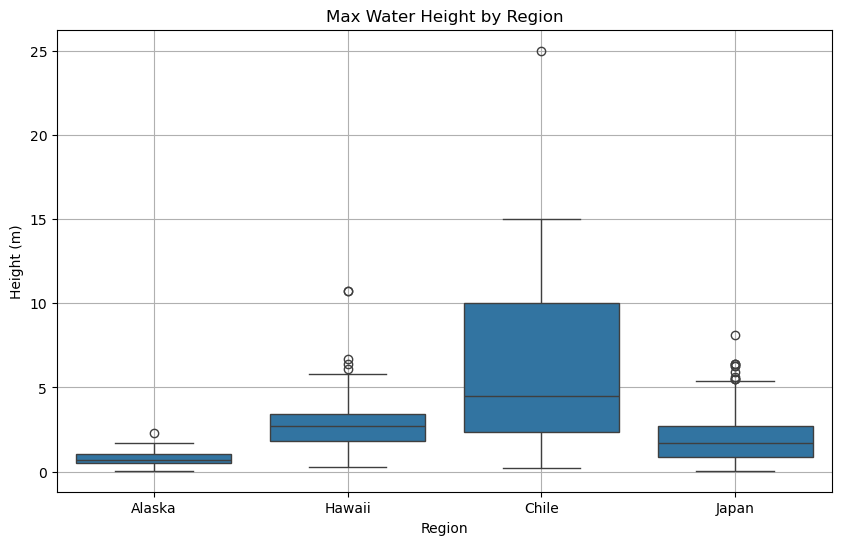

In [35]:
# Plot max water heights

plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Max Water Height (m)', data=df_filtered)
plt.title("Max Water Height by Region")
plt.ylabel("Height (m)")
plt.grid(True)
plt.show()

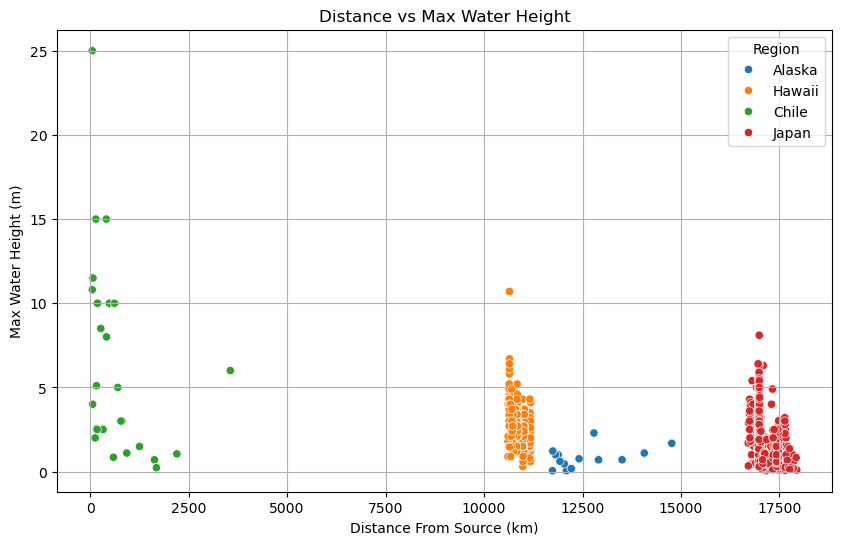

In [36]:
# plot distance vs max wave height

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Distance From Source (km)', y='Max Water Height (m)', hue='Region')
plt.title("Distance vs Max Water Height")
plt.grid(True)
plt.show()

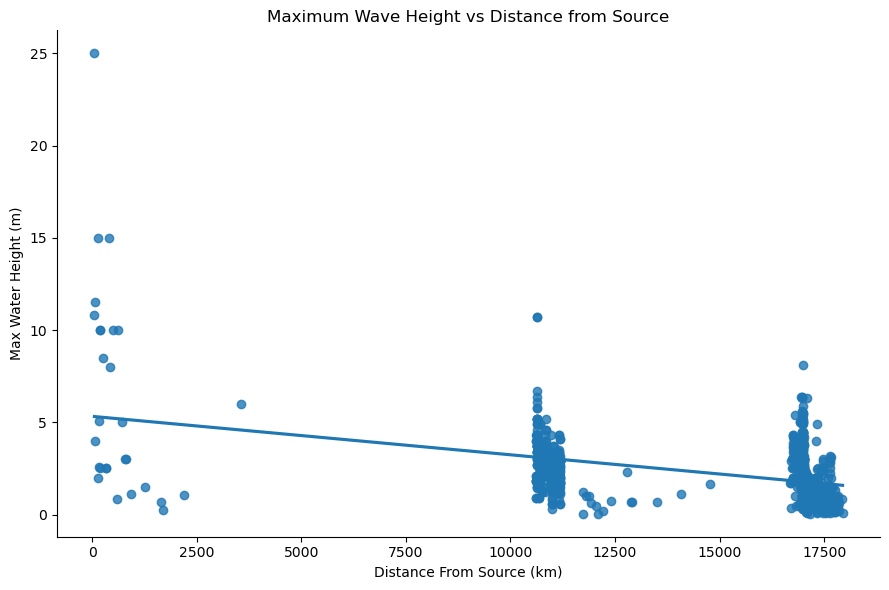

In [37]:
# plot with trend line
sns.lmplot(
    data=df_filtered,
    x='Distance From Source (km)',
    y='Max Water Height (m)',
    height=6,
    aspect=1.5,
    ci=None  
)

plt.title("Maximum Wave Height vs Distance from Source")
plt.tight_layout()
plt.show()

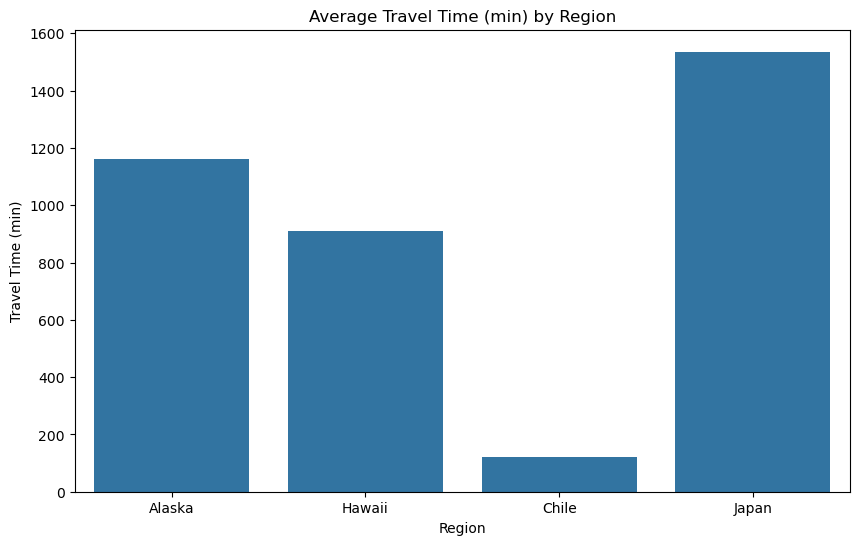

In [38]:
# plot travel times

df_filtered = df_regions[[
    'Region', 'Location Name', 'Latitude', 'Longitude',
    'Distance From Source (km)', 'Travel Hours', 'Travel Minutes',
    'Max Water Height (m)', 'Max Inundation Distance (m)',
    'Deaths', 'Injuries', 'Damage $Mil'
]].copy()


df_filtered.loc[:, 'Travel Time (min)'] = (
    df_filtered['Travel Hours'] * 60 + df_filtered['Travel Minutes']
)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x='Region', y='Travel Time (min)', estimator='mean', errorbar=None)
plt.title("Average Travel Time (min) by Region")
plt.show()



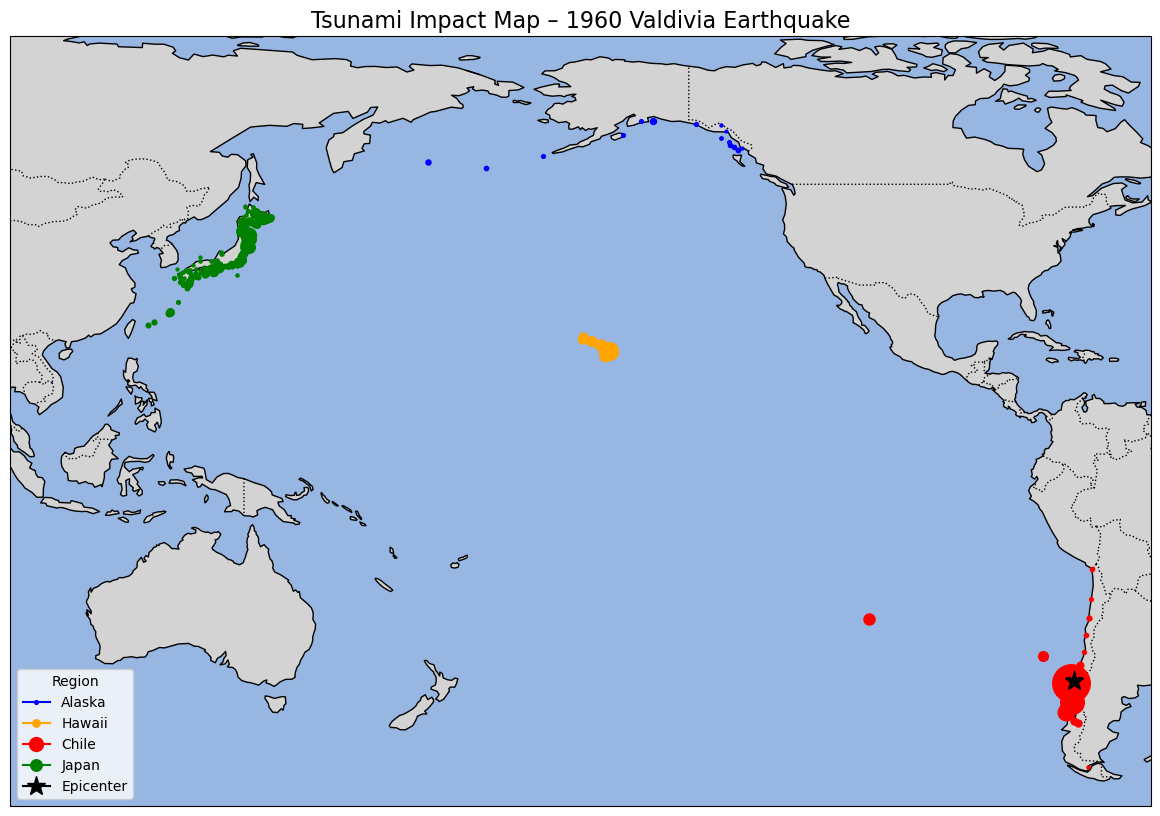

In [39]:
df_all = df_filtered.copy()

# Clean data
df_all['Latitude'] = pd.to_numeric(df_all['Latitude'], errors='coerce')
df_all['Longitude'] = pd.to_numeric(df_all['Longitude'], errors='coerce')
df_all['Max Water Height (m)'] = pd.to_numeric(df_all['Max Water Height (m)'], errors='coerce')

map_df = df_all.dropna(subset=['Latitude', 'Longitude', 'Max Water Height (m)']).copy()

# Normalize longitudes 
map_df['Plot_Longitude'] = map_df['Longitude'].apply(lambda lon: lon if lon <= 180 else lon - 360)

# Region colors
region_colors = {'Alaska': 'blue', 'Hawaii': 'orange', 'Chile': 'red', 'Japan': 'green'}

# Create map with Pacific center
plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title("Tsunami Impact Map – 1960 Valdivia Earthquake", fontsize=16)

ax.set_extent([100, -60 + 360, -60, 75], crs=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)

# Plot each tsunami report
for _, row in map_df.iterrows():
    ax.plot(
        row['Plot_Longitude'], row['Latitude'],
        marker='o',
        markersize=2 + row['Max Water Height (m)'],
        color=region_colors.get(row['Region'], 'gray'),
        transform=ccrs.PlateCarree(),
        label=row['Region'] if row['Region'] not in ax.get_legend_handles_labels()[1] else ""
    )
# Plot the epicenter
ax.plot(
    -73.407, -38.143,  # longitude, latitude
    marker='*',
    color='black',
    markersize=14,
    label='Epicenter',
    transform=ccrs.PlateCarree()
)

# Add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Region", loc='lower left')

plt.show()

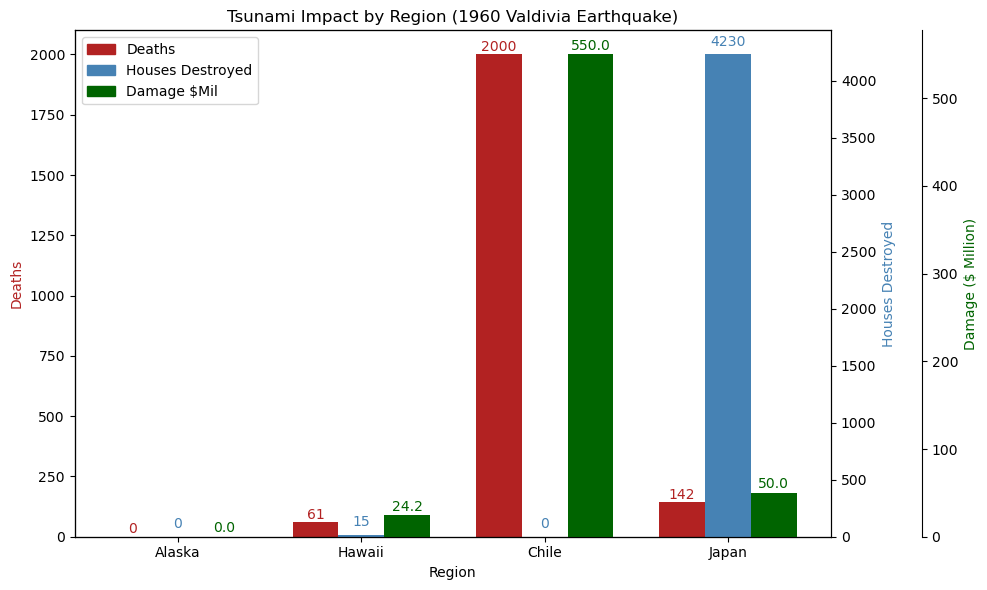

In [40]:
# Plot impact graph

# Define regions
def assign_region(row):
    if row['Country'] == 'CHILE':
        return 'Chile'
    elif row['Country'] == 'JAPAN':
        return 'Japan'
    elif row['Country'] == 'USA' and row['Area'] == 'HI':
        return 'Hawaii'
    elif row['Country'] == 'USA' and row['Area'] == 'AK':
        return 'Alaska'
    else:
        return None

df['Region'] = df.apply(assign_region, axis=1)

# Clean
for col in ['Deaths', 'Houses Destroyed', 'Damage $Mil']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Separate into ALL OF and city-level
df_allof = df[df['Location Name'].str.upper().str.contains("ALL OF", na=False)].copy()
df_city = df[~df['Location Name'].str.upper().str.contains("ALL OF", na=False)].copy()

# Summary DataFrame
regions = ['Alaska', 'Hawaii', 'Chile', 'Japan']
summary_data = []

for region in regions:
    if region in df_allof['Region'].values:
        row = df_allof[df_allof['Region'] == region][['Deaths', 'Houses Destroyed', 'Damage $Mil']].iloc[0]
    else:
        row = df_city[df_city['Region'] == region][['Deaths', 'Houses Destroyed', 'Damage $Mil']].sum()
    row['Region'] = region
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)[['Region', 'Deaths', 'Houses Destroyed', 'Damage $Mil']]
summary_df.fillna(0, inplace=True)

# Clarify Japan's missing death value (for some reason this kept giving me trouble, hence this step)
summary_df.loc[summary_df['Region'] == 'Japan', 'Deaths'] = 142

# Plot multi-axis bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.12))  # offset third axis

bar_width = 0.25
x = np.arange(len(summary_df))
regions = summary_df['Region']

bars1 = ax1.bar(x - bar_width, summary_df['Deaths'], width=bar_width, color='firebrick', label='Deaths')
bars2 = ax2.bar(x, summary_df['Houses Destroyed'], width=bar_width, color='steelblue', label='Houses Destroyed')
bars3 = ax3.bar(x + bar_width, summary_df['Damage $Mil'], width=bar_width, color='darkgreen', label='Damage $Mil')

# Axis labels and ticks
ax1.set_ylabel("Deaths", color='firebrick')
ax2.set_ylabel("Houses Destroyed", color='steelblue')
ax3.set_ylabel("Damage ($ Million)", color='darkgreen')
ax1.set_xlabel("Region")
ax1.set_xticks(x)
ax1.set_xticklabels(regions)
plt.title("Tsunami Impact by Region (1960 Valdivia Earthquake)")

# Value labels
for i, value in enumerate(summary_df['Deaths']):
    ax1.text(x[i] - bar_width, value + 2, f'{int(value)}', ha='center', va='bottom', color='firebrick')

for i, value in enumerate(summary_df['Houses Destroyed']):
    ax2.text(x[i], value + 50, f'{int(value)}', ha='center', va='bottom', color='steelblue')

for i, value in enumerate(summary_df['Damage $Mil']):
    ax3.text(x[i] + bar_width, value + 2, f'{value:.1f}', ha='center', va='bottom', color='darkgreen')

# Legend
handles = [
    plt.Rectangle((0, 0), 1, 1, color='firebrick'),
    plt.Rectangle((0, 0), 1, 1, color='steelblue'),
    plt.Rectangle((0, 0), 1, 1, color='darkgreen')
]
labels = ['Deaths', 'Houses Destroyed', 'Damage $Mil']
ax1.legend(handles, labels, loc='upper left')

plt.tight_layout()
plt.show()